
Домашнее задание «Модели ARIMA»

Выберите ряд из первого задания и постройте его модель ARIMA

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
%matplotlib inline

In [2]:
import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from warnings import filterwarnings
filterwarnings('ignore')

In [12]:
df = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [13]:
df.head()

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43


In [15]:
df['weekly_ret'] = np.log(df['Close']).diff()
df.head()

,Week,Close,weekly_ret
0,1971-W27,890.19,NaN
1,1971-W28,901.80,0.012958
2,1971-W29,888.51,-0.014847
3,1971-W30,887.78,-0.000822
4,1971-W31,858.43,-0.033619


In [16]:
# drop null rows
df.dropna(inplace=True)

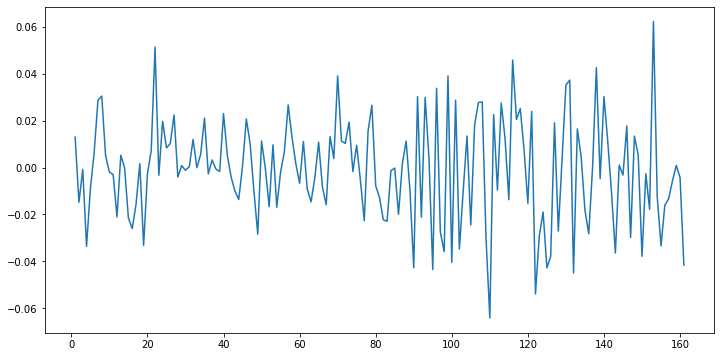

In [17]:
df.weekly_ret.plot(kind='line', figsize=(12, 6));

In [19]:
udiff = df.drop(['Close'], axis=1)
udiff.head()

,Week,weekly_ret
1,1971-W28,0.012958
2,1971-W29,-0.014847
3,1971-W30,-0.000822
4,1971-W31,-0.033619
5,1971-W32,-0.009151


In [20]:
rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

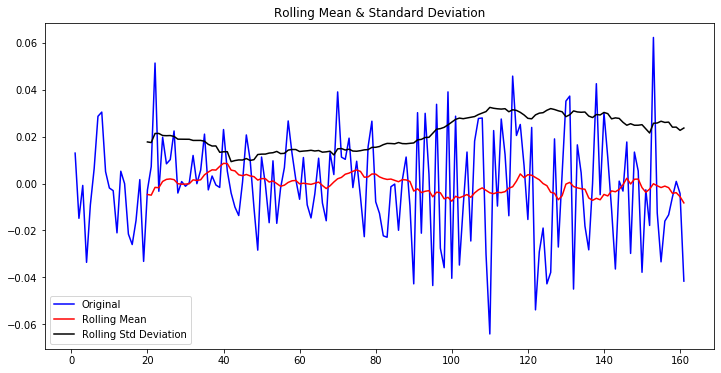

In [24]:
plt.figure(figsize=(12, 6))
orig = plt.plot(udiff['weekly_ret'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show(block=False)

In [25]:
# Perform Dickey-Fuller test
dftest = sm.tsa.adfuller(udiff.weekly_ret, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value ({0})'.format(key)] = value
    
dfoutput

Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64

P-value меньше 0.05% следоватаельно ряд стационарен

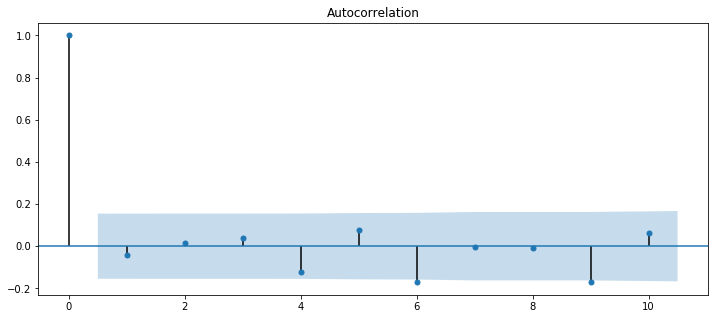

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

# the autocorrelation chart provides just the correlation at increasing lags
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff['weekly_ret'].values, lags=10, ax=ax)
plt.show()

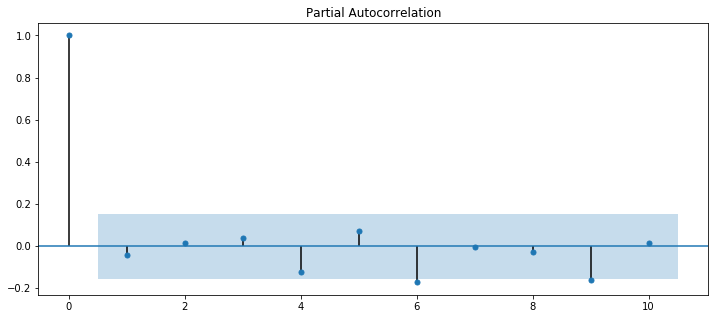

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(udiff['weekly_ret'].values, lags=10, ax=ax)
plt.show()

In [74]:
from statsmodels.tsa.arima_model import ARMA

ar1 = ARMA(tuple(udiff['weekly_ret'].values), (3, 3)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  161
Model:                     ARMA(3, 3)   Log Likelihood                 390.681
Method:                       css-mle   S.D. of innovations              0.021
Date:                Sun, 31 Jan 2021   AIC                           -765.361
Time:                        23:48:27   BIC                           -740.710
Sample:                             0   HQIC                          -755.352
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -0.786      0.432      -0.003       0.001
ar.L1.y       -0.7079      0.120     -5.881      0.000      -0.944      -0.472
ar.L2.y        0.5015      0.173      2.892      0.004       0.162       0.841
ar.L3.y        0.8426      0.114      7.406      0.000       0.620       1.066
ma.L1.y        0.6471      0.115      5.623      0.000       0.422       0.873
ma.L2.y       -0.6011      0.145     -4.156      0.000      -0.885      -0.318
ma.L3.y       -0.8159      0.105     -7.760      0.000      -1.022      -0.610
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1144           -0.0000j            1.1144           -0.0000
AR.2           -0.8548           -0.5782j            1.0320           -0.4053
AR.3           -0.8548           +0.5782j            1.0320            0.4053
MA.1            1.0714           -0.0000j            1.0714           -0.0000
MA.2           -0.9041           -0.5716j            1.0696           -0.4103
MA.3           -0.9041           +0.5716j            1.0696            0.4103
-----------------------------------------------------------------------------
"""

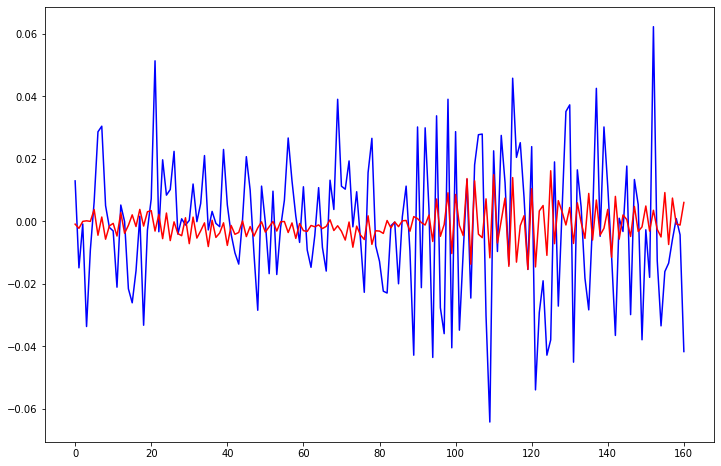

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'].values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

Как видим, модель пока не очень хорошо предсказывает

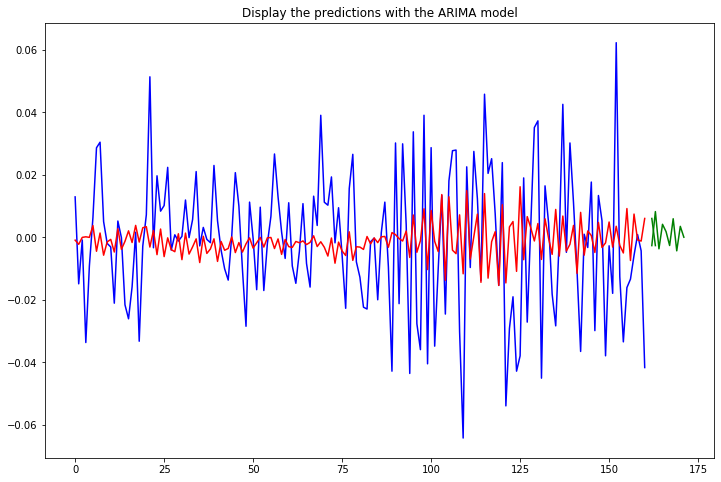

In [76]:
steps = 10

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'].values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff['weekly_ret'].values)+1, 
                                                                      len(udiff['weekly_ret'].values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff['weekly_ret'].values)+1, 
                                           len(udiff['weekly_ret'].values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

Пока что только так у меня получилось. Не понимаю, как можно еще улучшить модель

In [77]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [78]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

aic: -770.01581 | order: (2, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -1.183714e+01
p-value                        7.742674e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


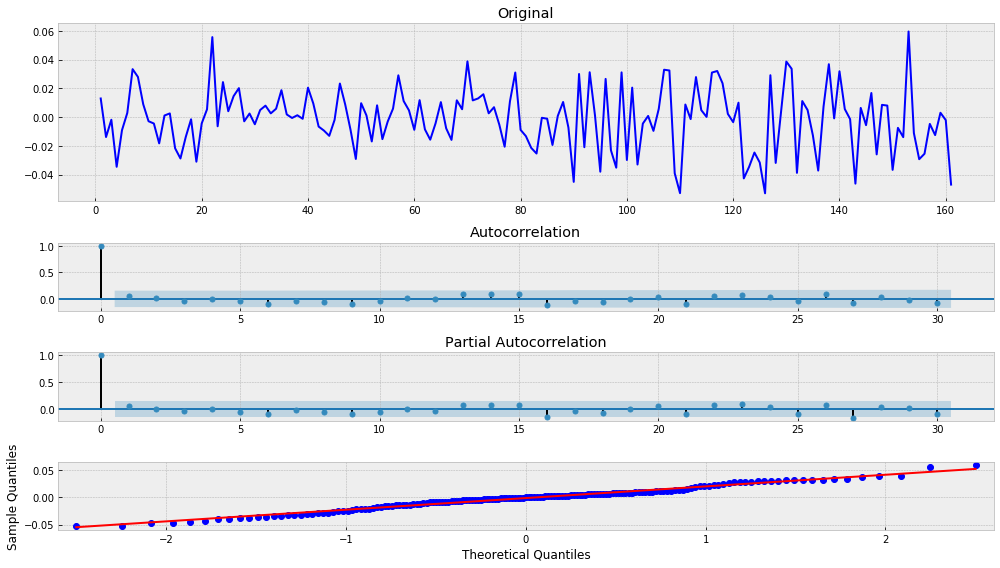

In [79]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(udiff['weekly_ret'], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

Попробуем еще раз с параметрами 2 и 2

In [81]:
from statsmodels.tsa.arima_model import ARMA

ar1 = ARMA(tuple(udiff['weekly_ret'].values), (2, 2)).fit()
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  161
Model:                     ARMA(2, 2)   Log Likelihood                 386.624
Method:                       css-mle   S.D. of innovations              0.022
Date:                Sun, 31 Jan 2021   AIC                           -761.247
Time:                        23:49:24   BIC                           -742.759
Sample:                             0   HQIC                          -753.740
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.777      0.437      -0.003       0.001
ar.L1.y        0.0281      0.171      0.164      0.869      -0.307       0.363
ar.L2.y        0.7049      0.160      4.396      0.000       0.391       1.019
ma.L1.y       -0.0412      0.142     -0.291      0.771      -0.319       0.237
ma.L2.y       -0.7990      0.132     -6.031      0.000      -1.059      -0.539
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1713           +0.0000j            1.1713            0.0000
AR.2           -1.2112           +0.0000j            1.2112            0.5000
MA.1            1.0933           +0.0000j            1.0933            0.0000
MA.2           -1.1448           +0.0000j            1.1448            0.5000
-----------------------------------------------------------------------------
"""

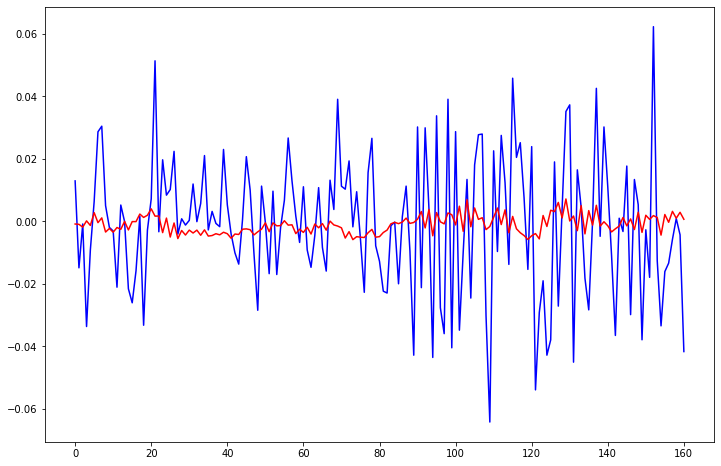

In [82]:
plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'].values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

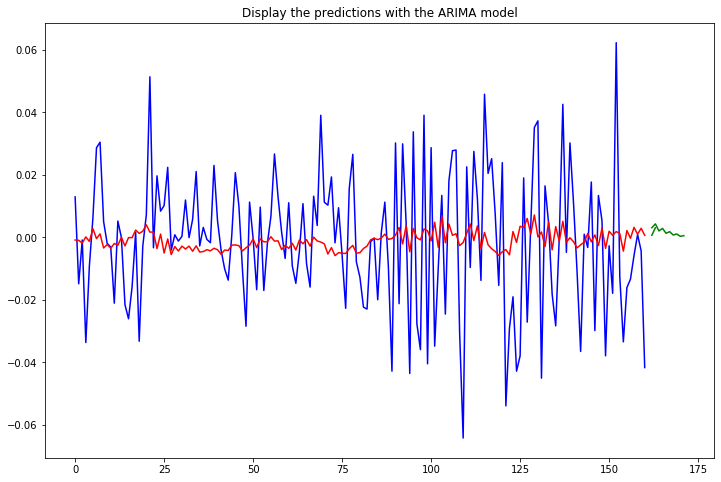

In [83]:
steps = 10

forecast = ar1.forecast(steps=steps)[0]

plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'].values, color='blue')

preds = ar1.fittedvalues
plt.plot(preds, color='red')

plt.plot(pd.DataFrame(np.array([preds[-1],forecast[0]]).T,index=range(len(udiff['weekly_ret'].values)+1, 
                                                                      len(udiff['weekly_ret'].values)+3)), color='green')
plt.plot(pd.DataFrame(forecast,index=range(len(udiff['weekly_ret'].values)+1, 
                                           len(udiff['weekly_ret'].values)+1+steps)), color='green')
plt.title('Display the predictions with the ARIMA model')
plt.show()

Еще хуже стало:(